Analyzing serial neurogym results

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

class Args():
    def __init__(self):
        self.exp_name = 'gates_search'
        self.var1 = 1
        self.var2 = 0.1
        self.same_rnn = True
        self.use_gates = True
        self.train_to_criterion = True
        self.num_of_tasks = 15
args = Args() 

exp_name = args.exp_name
os.makedirs('./files/'+exp_name, exist_ok=True)

###--------------------------Training configs--------------------------###

# set device
device = 'cuda' # always CPU
# Config
config = {
    # exp:
    'exp_name': exp_name,
    # envs
    'tasks': ['yang19.dlygo-v0',
            'yang19.rtgo-v0',
            'yang19.dlyanti-v0',
            'yang19.go-v0',
            'yang19.dms-v0',
            'yang19.dnms-v0',
            'yang19.dmc-v0',
            'yang19.dnmc-v0',
            'yang19.dm1-v0',
            'yang19.dm2-v0',
            'yang19.ctxdm1-v0',
            'yang19.ctxdm2-v0',
            'yang19.multidm-v0',
            'yang19.anti-v0',
            'yang19.rtanti-v0'
            ],
    'env_kwargs': {'dt': 100},
    'seq_len': 50,
# Training
    'trials_per_task' : 200000,
    'batch_size' : 100,
    'print_every_batches': 100,
    'train_to_criterion': bool(args.train_to_criterion),
    'device': device,
# model
    'use_lstm': False,
    'same_rnn' : bool(args.same_rnn), 
    'use_gates': bool(args.use_gates), 
    'md_mean' : args.var1,
    'md_range': args.var2, #0.1
    'use_external_inputs_mask': False,
    'input_size': 33,
    'hidden_size': 256,
    'sub_size': 128,
    'output_size': 17,
    'num_task': 2,
    'MDeffect': False,
    'md_size': 15,
    'md_active_size': 5,
    'md_dt': 0.001,
# optimizer
    'lr': 1e-4, # 1e-4 for CTRNN, 1e-3 for LSTM
}
config.update({'tasks': config['tasks'][:args.num_of_tasks]})
config.update({'human_task_names': ['{:<6}'.format(tn[7:-3]) for tn in config['tasks']]})
config.update({'md_size': len(config['tasks'])})

exp_signature = config['exp_name'] +f'_{args.var1}_{args.var2}_'+\
    f'{"same_rnn" if config["same_rnn"] else "separate"}_{"gates" if config["use_gates"] else "nogates"}'+\
        f'_{"tc" if config["train_to_criterion"] else "nc"}'
print(exp_signature)

task_seq = []
# Add tasks gradually with rehearsal 1 2 1 2 3 1 2 3 4 ...
task_sub_seqs = [[(i, config['tasks'][i]) for i in range(s)] for s in range(2, len(config['tasks']))] # interleave tasks and add one task at a time
for sub_seq in task_sub_seqs: task_seq+=sub_seq

# Just sequence the tasks serially
simplified_task_seq = [(i, config['tasks'][i]) for i in range(len(config['tasks']))]
task_seq = simplified_task_seq
# print('Task seq to be learned: ', task_seq)


gates_search_1_0.1_same_rnn_gates_tc


In [2]:
# one fig
file1= './files/gates_search/testing_logs_gates_search_1.0_0.1_same_rnn_gates_nc.npy'
file2= './files/same_rnn/testing_logs.npy'
file3= './files/separate_rnns/testing_logs.npy'

# label1 = 'no gates'
# label2 = 'with gates \u03bc(1, 0.1)'
label = 'Separate RNNs'
# label = 'Same RNN'

testing_logs = np.load( file3, allow_pickle=True)
logs = testing_logs

num_tasks = len(config['tasks'])
title_label = 'Training tasks sequentially ---> \n    ' + label 
plt.close('all')
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)
        if li == 0: ax.set_title(config['human_task_names'][logi])
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
# exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
#       mul_gate: {"True" if config["use_gates"] else "False"}\
#           {exp_signature}'
# axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig('./files/'+label+'_all_logs.png', dpi=300)


FileNotFoundError: [Errno 2] No such file or directory: './files/separate_rnns/testing_logs.npy'

In [ ]:
import os
os.getcwd()

In [28]:

file1= './files/gates_search/testing_logs_gates_search_1.0_0.1_same_rnn_gates_nc.npy'
file2= './files/same_rnn/testing_logs.npy'
file3= './files/separate_rnns/testing_logs.npy'

file1 = './../files/search_gates_ones/testing_logs_search_gates_ones_0.0_0.5_same_rnn_gates_nc.npy'
# file2 = './../files/search_gates_ones/testing_logs_search_gates_ones_0.0_0.9_same_rnn_gates_nc.npy'
file2 = './../files/search_gates_ones/testing_logs_search_gates_ones_0.0_1.0_same_rnn_gates_nc.npy'

# label1 = 'sep RNNs'
# label2 = 'same RNN'

label1 = 'Binary gates 50% ones'
label2 = 'No gates'

testing_logs1 = np.load( file1, allow_pickle=True)
testing_logs2 = np.load( file2, allow_pickle=True)

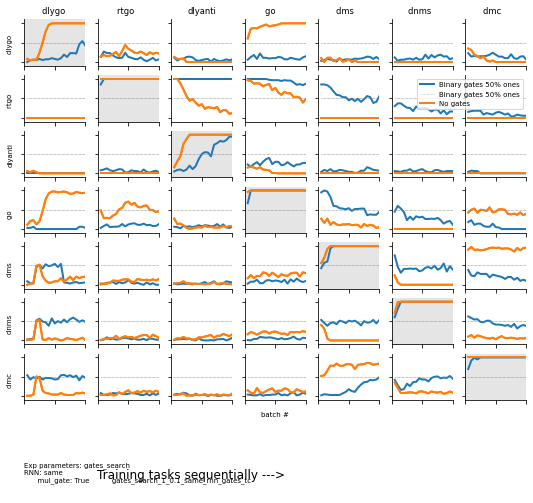

In [29]:
# two figs 
plt.close('all')
logs = testing_logs1
num_tasks = len(logs)
title_label = 'Training tasks sequentially ---> \n    ' #+ config['exp_name']
max_x = config['trials_per_task']//config['batch_size']
fig, axes = plt.subplots(num_tasks,num_tasks, figsize=[9,7])
for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        log = testing_logs1[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, label=label1)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5, label=label1)
        if True:
            log = testing_logs2[logi]
            ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2, color='tab:orange', label=label2)

        if li == 0: ax.set_title(config['human_task_names'][logi])
            
        if logi == 0: ax.set_ylabel(config['human_task_names'][li])
        ax.set_yticklabels([]) 
        ax.set_xticklabels([])
        if logi== li:
            ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
        if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
            ax.set_xlabel('batch #')
axes[1, num_tasks-1].legend()

for logi in range(num_tasks):
    for li in range(num_tasks):
        ax = axes[ li, logi ] # log i goes to the col direction -->
        log = testing_logs2[logi]
        ax.plot(log['stamps'], [test[li] for test in log['accuracy']], linewidth=2)
        ax.plot(log['stamps'], np.ones_like(log['stamps'])*0.5, ':', color='grey', linewidth=0.5)

        
axes[num_tasks-1, num_tasks//2-2].text(-8., -2.5, title_label, fontsize=12)     
exp_parameters = f'Exp parameters: {config["exp_name"]}\nRNN: {"same" if config["same_rnn"] else "separate"}\n\
      mul_gate: {"True" if config["use_gates"] else "False"}\
          {exp_signature}'
axes[num_tasks-1, 0].text(-7., -2.2, exp_parameters, fontsize=7)
# plt.show(fig)
plt.savefig(f'./files/{label1}_vs_{label2}.png', dpi=300)

In [7]:
len(logs)

7

In [8]:
def extract_accuracies(logs):
    train = []
    test = []
    num_tasks = len(logs)
    for logi in range(num_tasks):
        for task_i in range(num_tasks):
            log = logs[logi]
            if logi== task_i:
                train.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    #                 log['accuracy']task_i])
            else:
                test.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
    return(np.stack(train), np.stack(test))


def extract_accuracies_all(logs):
    train = []

    num_tasks = len(logs)
    for logi in range(num_tasks):
        task_tests = []
        for task_i in range(num_tasks):
            log = logs[logi]
            task_tests.append(np.array([t[task_i] for t in logs[logi]['accuracy']]))
        train.append(task_tests)
    return(np.stack(train))


# def get_np_acc(logs, num_tasks):
#     logs_tasks_tests_acc = []
#     for logi in range(len(logs)):
#         test_accuracies = []
#         for task_i in range(num_tasks):
#             test_accuracies.append([t[task_i] for t in logs[logi]['accuracy']])
#         logs_tasks_tests_acc.append(np.stack(test_accuracies))

#     ltta = np.stack(logs_tasks_tests_acc)
#     return(ltta)


# tr_acc = get_np_acc(train, 15)
# te_acc = get_np_acc(test, 15)

In [31]:
tr1, te1 = extract_accuracies(testing_logs1)
tr2, te2 = extract_accuracies(testing_logs2)


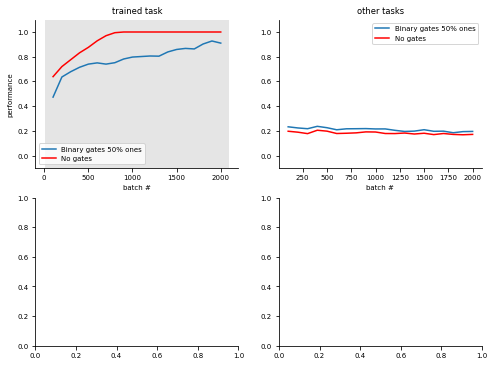

In [32]:
fig, axes = plt.subplots(2,2, figsize=(8,6))
ax = axes[0,0]
ax.set_title('trained task')
ax.plot(testing_logs1[0]['stamps'], tr1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], tr2.mean(axis=(0)), color='red', label=label2)
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
ax.set_ylim([-0.1, 1.1])
ax.set_ylabel('performance')
ax.set_xlabel('batch #')
ax.legend()

ax = axes[0,1]
ax.set_title('other tasks')
ax.plot(testing_logs1[0]['stamps'], te1.mean(axis=(0)), label=label1)
ax.plot(testing_logs2[0]['stamps'], te2.mean(axis=(0)), color= 'red', label=label2)
ax.set_xlabel('batch #')
ax.legend()

ax.set_ylim([-0.1, 1.1])
# fig.savefig('./files/gates_no_gates_comp.jpg')
fig.savefig(f'./files/{label1}_{label2}comp.png', dpi=600)

logs[0]['accuracy'] has 20 enteries for each time step, and each entry has accuracy of all tasks at that time step.

In [9]:
tt = extract_accuracies_all(logs)

Text(0.5, 1.0, 'upper')

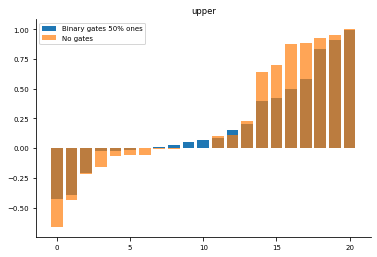

In [39]:
def get_diffs(logs, triangle='upper', k=1):
    '''take a log, and return the improvement in the mean accuracy of tasks
    triangle: look at "upper" or "lower" triangle corrospondin to "after" or "before" index task was trained
    k: take from diagonal (0) or above it (1) or below it (-1)'''
    
    tt = extract_accuracies_all(logs)
    tavg = tt.mean(-1)

    tdiff = tavg[1:, :] -  tavg[:-1, :]    
    if triangle == 'upper':
        tri = tdiff[np.triu_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
    elif (triangle == 'lower'):
        tri = tdiff[np.tril_indices_from(tdiff,k)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri    
    
    sorted_diffs = np.sort(tri)
    return(sorted_diffs)


comp1 = get_diffs(testing_logs1, 'upper', 1)
comp2 = get_diffs(testing_logs2, 'upper', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('upper')


Text(0.5, 1.0, 'lower')

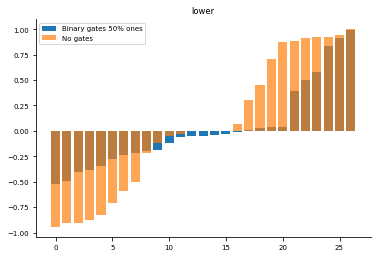

In [40]:
comp1 = get_diffs(testing_logs1, 'lower', 1)
comp2 = get_diffs(testing_logs2, 'lower', 1)

# lt = get_diffs(logs, 'lower', -1)
_=plt.bar(range(comp1.shape[0]), np.sort(comp1), label=label1)
_=plt.bar(range(comp2.shape[0]), np.sort(comp2), alpha = 0.7, label=label2)
plt.legend()
plt.gca().set_title('lower')


In [45]:
comp1.mean()

0.026425926

In [47]:
comp2.mean()

0.04837036

In [9]:
tavg = tt.mean(-1)

In [10]:
tavg

array([[0.1595    , 0.        , 0.        , 0.0135    , 0.251     ,
        0.43199998, 0.48399997],
       [0.12349999, 0.99300003, 0.06599999, 0.097     , 0.039     ,
        0.036     , 0.0555    ],
       [0.0675    , 1.        , 0.46199998, 0.07049999, 0.0375    ,
        0.0235    , 0.033     ],
       [0.1085    , 0.954     , 0.2595    , 0.9835    , 0.0905    ,
        0.052     , 0.0425    ],
       [0.0775    , 0.57199997, 0.071     , 0.57799995, 0.92700005,
        0.47199994, 0.19150001],
       [0.10699999, 0.22749999, 0.06399999, 0.299     , 0.4355    ,
        0.971     , 0.39549997],
       [0.148     , 0.10699999, 0.0115    , 0.0615    , 0.215     ,
        0.44649997, 0.978     ]], dtype=float32)

In [11]:
tdiff = tavg[1:, :] -  tavg[:-1, :]

In [12]:
tdiff.shape

(6, 7)

In [45]:
np.triu(tdiff,1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

array([[ 0.        ,  0.99300003,  0.06599999,  0.08350001, -0.21199998],
       [ 0.        ,  0.        ,  0.396     , -0.02650001, -0.0015    ],
       [ 0.        ,  0.        ,  0.        ,  0.913     ,  0.053     ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.83650005],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [49]:
np.tril(tdiff,-1)[:5,:5] # returns the matrix with zeros outside of upper triangle. Passing k=1 lifts up the tri to above the first diagnoal

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05599999,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.041     , -0.046     ,  0.        ,  0.        ,  0.        ],
       [-0.031     , -0.38200003, -0.18849999,  0.        ,  0.        ],
       [ 0.02949999, -0.34449998, -0.00700001, -0.27899995,  0.        ]],
      dtype=float32)

In [34]:
ut = tdiff[np.triu_indices_from(tdiff,1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri
lt = tdiff[np.tril_indices_from(tdiff,-1)] # this just return the values of all the upper triangular locations above diagonal 1. Pass - instead to get all upper tri

In [33]:
tdiff[np.tril_indices_from(tdiff,-1)]

array([-0.05599999,  0.041     , -0.046     , -0.031     , -0.38200003,
       -0.18849999,  0.02949999, -0.34449998, -0.00700001, -0.27899995,
        0.04100001, -0.1205    , -0.05249999, -0.2375    , -0.22049999],
      dtype=float32)

In [47]:
tdiff.shape

(6, 7)

<BarContainer object of 15 artists>

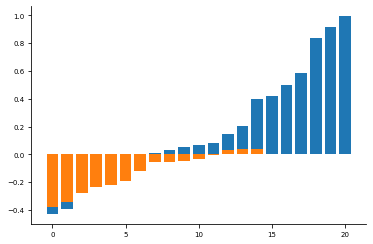

In [35]:
plt.bar(range(ut.shape[0]), np.sort(ut))
plt.bar(range(lt.shape[0]), np.sort(lt))


In [28]:
help(np.sort)

Help on function sort in module numpy:

sort(a, axis=-1, kind=None, order=None)
    Return a sorted copy of an array.
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    axis : int or None, optional
        Axis along which to sort. If None, the array is flattened before
        sorting. The default is -1, which sorts along the last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
        and 'mergesort' use timsort or radix sort under the covers and, in general,
        the actual implementation will vary with data type. The 'mergesort' option
        is retained for backwards compatibility.
    
        .. versionchanged:: 1.15.0.
           The 'stable' option was added.
    
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A si

In [ ]:
te1.shape

In [ ]:
with_gates_te = te_acc
with_gates_tr = tr_acc

In [ ]:

fig, ax = plt.subplots(1)
logs = testing_logs

train = []
test = []
for logi in range(num_tasks):
    for li in range(num_tasks):
        log = testing_logs[logi]
        if logi== li:
            train.append(logs[logi]['accuracy'])
        else:
            test.append(logs[logi]['accuracy'])

    
            
train = np.stack(train)
test = np.stack(test)
print(train.shape)
print(test.shape)
ax.set_ylim([-0.1,1.1])
ax.set_xlim([0, max_x])
ax.plot(log['stamps'], train.mean(axis=0), linewidth=2)
ax.plot(log['stamps'], test.mean(axis=0), color='grey', linewidth=2)
# if li == 0: ax.set_title(config['human_task_names'][logi])
# if logi == 0: ax.set_ylabel(config['human_task_names'][li])
ax.set_yticklabels([]) 
ax.set_xticklabels([])
        
ax.axvspan(*ax.get_xlim(), facecolor='grey', alpha=0.2)
if li == num_tasks-1 and logi in [num_tasks//2 - 4, num_tasks//2, num_tasks//2 + 4] :
    ax.set_xlabel('batch #')


In [ ]:
np.stack(train[0][0].values())

In [ ]:
logs[0]['accuracy']

In [ ]:
test_accuracies = []
for task_i in range(15):
    test_accuracies.append([test[task_i] for test in logs[0]['accuracy']])


In [ ]:
ta = np.stack(test_accuracies)

In [ ]:

ta.shape

In [ ]:
ta

In [ ]:
task_i = 0
zz= zip(log['stamps'], [test[task_i] for test in logs[0]['accuracy']])

In [ ]:
[print( (z, a)) for z, a in zz]